In [ ]:

!pip install tensorflow


Defaulting to user installation because normal site-packages is not writeable


100%|██████████| 2.10G/2.10G [02:16<00:00, 16.5MB/s]

Extracting files...


Path to dataset files: C:\Users\Tharun\.cache\kagglehub\datasets\hendrichscullen\vehide-dataset-automatic-vehicle-damage-detection\versions\1
Defaulting to user installation because normal site-packages is not writeable


In [2]:
import os
import shutil
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.decomposition import PCA

# Reproducibility
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)


C:\Users\Tharun\AppData\Roaming\Python\Python313\site-packages\keras\src\export\tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


In [ ]:
# NOTE: images are ONE LEVEL DEEPERe-damage-detection\versions\1\
TRAIN_IMAGES_DIR = os.path.join("image","image")
VAL_IMAGES_DIR   = os.path.join("validation","validation")

# CNN-compatible output folders
OUT_BASE  = "cnn_data"
OUT_TRAIN = os.path.join(OUT_BASE, "train")
OUT_VAL   = os.path.join(OUT_BASE, "val")


SyntaxError: (unicode error) 'unicodeescape' codec can't decode bytes in position 2-3: truncated \UXXXXXXXX escape (3124269938.py, line 2)

In [ ]:
def copy_all_images(src_dir, out_dir):
    damage_dir = os.path.join(out_dir, "damage")
    os.makedirs(damage_dir, exist_ok=True)

    copied = 0
    for img in os.listdir(src_dir):
        src = os.path.join(src_dir, img)
        dst = os.path.join(damage_dir, img)

        if os.path.isfile(src):
            shutil.copy(src, dst)
            copied += 1

    print(f"Copied {copied} images into {damage_dir}")


copy_all_images(TRAIN_IMAGES_DIR, OUT_TRAIN)
copy_all_images(VAL_IMAGES_DIR, OUT_VAL)


Copied 11621 images into cnn_data\train\damage
Copied 2324 images into cnn_data\val\damage


In [ ]:
# Cell 4: Robust Data Loading using tf.data (final, warning-free)

from PIL import ImageFile
import tensorflow as tf

ImageFile.LOAD_TRUNCATED_IMAGES = True

IMG_SIZE = (128, 128)
BATCH_SIZE = 16
SEED = 42

train_ds = tf.keras.utils.image_dataset_from_directory(
    "cnn_data/train",
    labels="inferred",
    label_mode="categorical",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=SEED
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    "cnn_data/val",
    labels="inferred",
    label_mode="categorical",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False
)

normalization_layer = tf.keras.layers.Rescaling(1./255)

train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds   = val_ds.map(lambda x, y: (normalization_layer(x), y))

# ✅ NEW API (no warning)
train_ds = train_ds.ignore_errors()
val_ds   = val_ds.ignore_errors()

AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(AUTOTUNE)
val_ds   = val_ds.prefetch(AUTOTUNE)

print("Cell 4 completed: datasets ready, corrupted images skipped safely.")



Found 11621 files belonging to 1 classes.
Found 2324 files belonging to 1 classes.
Cell 4 completed: datasets ready, corrupted images skipped safely.


In [ ]:
from tensorflow.keras import layers, models

model = models.Sequential([
    layers.Conv2D(32, (3,3), activation="relu", input_shape=(128,128,3)),
    layers.MaxPooling2D(),

    layers.Conv2D(64, (3,3), activation="relu"),
    layers.MaxPooling2D(),

    layers.Conv2D(128, (3,3), activation="relu"),
    layers.MaxPooling2D(),

    layers.Flatten(),

    # 🔑 Embedding layer
    layers.Dense(128, activation="relu", name="embedding_layer"),

    layers.Dense(1, activation="softmax")  # single class
])

model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 126, 126, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 28, 28, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding_layer (Dense)              │ (None, 128)                 │       3,211,392 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,304,769 (12.61 MB)

 Trainable params: 3,304,769 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10
)


Epoch 1/10
    712/Unknown 122s 168ms/step - accuracy: 1.0000 - loss: 0.0000e+00

C:\Users\Tharun\AppData\Roaming\Python\Python313\site-packages\keras\src\trainers\epoch_iterator.py:164: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


712/712 ━━━━━━━━━━━━━━━━━━━━ 132s 182ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 2/10
712/712 ━━━━━━━━━━━━━━━━━━━━ 132s 185ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 3/10
712/712 ━━━━━━━━━━━━━━━━━━━━ 130s 182ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 4/10
712/712 ━━━━━━━━━━━━━━━━━━━━ 131s 184ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 5/10
712/712 ━━━━━━━━━━━━━━━━━━━━ 133s 186ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 6/10
712/712 ━━━━━━━━━━━━━━━━━━━━ 133s 187ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 7/10
712/712 ━━━━━━━━━━━━━━━━━━━━ 143s 201ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 8/10
712/712 ━━━━━━━━━━━━

In [ ]:
from tensorflow.keras import models
import numpy as np

# 🔑 Force model to build by calling it once
for images, _ in train_ds.take(1):
    _ = model(images)

# Create embedding model (NOW this will work)
embedding_model = models.Model(
    inputs=model.inputs,
    outputs=model.get_layer("embedding_layer").output
)

# Extract embeddings from validation set
embeddings = []
labels = []

for batch_images, batch_labels in val_ds:
    emb = embedding_model(batch_images, training=False)
    embeddings.append(emb.numpy())
    labels.append(batch_labels.numpy())

embeddings = np.vstack(embeddings)
labels = np.vstack(labels)

print("Embeddings shape:", embeddings.shape)


C:\Users\Tharun\AppData\Roaming\Python\Python313\site-packages\keras\src\ops\nn.py:947: UserWarning: You are using a softmax over axis -1 of a tensor of shape (16, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Embeddings shape: (2308, 128)


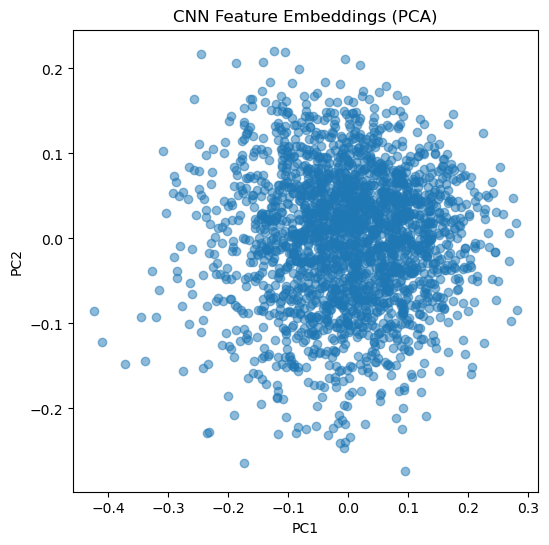

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
reduced = pca.fit_transform(embeddings)

plt.figure(figsize=(6,6))
plt.scatter(reduced[:,0], reduced[:,1], alpha=0.5)
plt.title("CNN Feature Embeddings (PCA)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()
